In [2]:
from helper import get_predator_prey_data, mse_trunc, \
    remove_single_data_point, int_cost_lotka_volterra
from workers import vary_truncation_worker
import shelve
import multiprocessing as mp
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
t, P = get_predator_prey_data()
from workers import vary_truncation_worker
import pandas as pd
import seaborn as sns

In [13]:
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [10]:
def remove_points_mean(P, n, min = False):
    means = np.mean(P, axis = 0)
    truncated_P = P.copy()
    relative_P = np.abs(P - means)
    x = relative_P[:,0]
    y = relative_P[:,1]
    if min:
        index_x = np.argsort(x)[:n]
        index_y = np.argsort(y)[:n]
    else:
        index_x = np.argsort(x)[-n:]
        index_y = np.argsort(y)[-n:]
        
    truncated_P[index_x,0] = -1
    truncated_P[index_y,1] = -1
    return truncated_P

In [11]:
def vary_truncation(trunc_datasets, P, t, rv, n_sim=100, T_start=200, T_steps=2000):
    manager = mp.Manager()
    results = manager.list()

    work_queue = mp.Queue()
    for i in range(len(trunc_datasets)):
        results.append(manager.list())
        for j in range(n_sim):
            work_queue.put((i, j))

    processes = []

    for i in range(10):
        p = mp.Process(target=vary_truncation_worker, args=(
            work_queue, results, T_start, T_steps, P, t, rv, trunc_datasets
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return [list(t) for t in results], trunc_datasets

In [18]:
if False: 
    np.random.seed(10081997)
    P_trunc_min_10 = remove_points_mean(P, 10, min= True)
    P_trunc_max_10 = remove_points_mean(P, 10, min= False)
    
    P_trunc_min_40 = remove_points_mean(P, 40, min= True)
    P_trunc_max_40 = remove_points_mean(P, 40, min= False)
    
    P_trunc_min_70 = remove_points_mean(P, 70, min= True)
    P_trunc_max_70 = remove_points_mean(P, 70, min= False)
    
    
    trunc_datasets_10 = [P_trunc_min_10, P_trunc_max_10]
    trunc_datasets_40 = [P_trunc_min_40, P_trunc_max_40]
    trunc_datasets_70 = [P_trunc_min_70, P_trunc_max_70]



    rv = [1, 1, 1, 1]
    results_10, _ = vary_truncation(trunc_datasets_10, P, t, rv, n_sim=500, T_start=200, T_steps=2000)
    results_40, _ = vary_truncation(trunc_datasets_40, P, t, rv, n_sim=500, T_start=200, T_steps=2000)
    results_70, _ = vary_truncation(trunc_datasets_70, P, t, rv, n_sim=500, T_start=200, T_steps=2000)

    
    shelf = shelve.open("Arrays/Special_data_removal")
    shelf["Costs_both_sets_10"] = results_10
    shelf["Costs_both_sets_40"] = results_40
    shelf["Costs_both_sets_70"] = results_70
    
    shelf.close()   

In [4]:
shelf = shelve.open("Arrays/Special_data_removal")
results_10 = shelf["Costs_both_sets_10"]
results_40 = shelf["Costs_both_sets_40"]
results_70 = shelf["Costs_both_sets_70"]
shelf.close()   

In [5]:
print(np.median(results_10, axis = 1))
print(np.mean(results_10, axis = 1))
print(np.min(results_10, axis = 1))
print(np.max(results_10, axis = 1))

[5.6570147  6.24550334]
[3.44707815 3.8463527 ]
[0.02189762 0.02346356]
[8.24503321 8.52322632]


In [6]:
print(np.median(results_40, axis = 1))
print(np.mean(results_40, axis = 1))
print(np.min(results_40, axis = 1))
print(np.max(results_40, axis = 1))

[6.00893749 7.47689076]
[22.36072886  5.48656307]
[0.02211082 0.01944883]
[9134.90593643  146.57393817]


In [7]:
print(np.median(results_70, axis = 1))
print(np.mean(results_70, axis = 1))
print(np.min(results_70, axis = 1))
print(np.max(results_70, axis = 1))

[0.32804587 5.99114408]
[3.96882758 4.01328344]
[0.01991179 0.02197477]
[ 13.79577865 123.08900969]


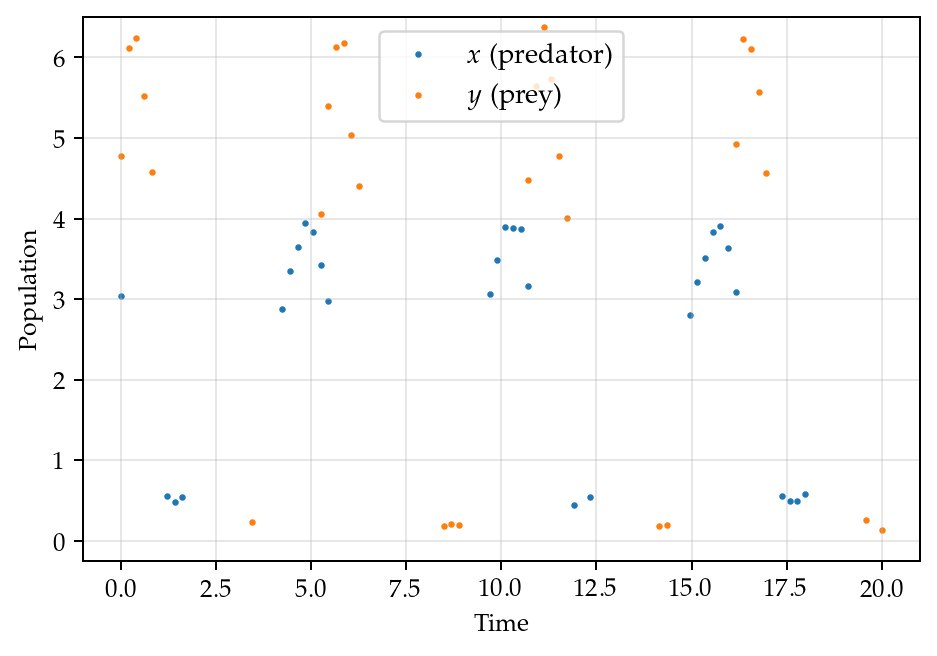

In [26]:
P_trunc_min_70 = remove_points_mean(P, 70, min= True)

plt.scatter(t, P_trunc_min_70[:,0], s=2.5, label="$x$ (predator)")
plt.scatter(t, P_trunc_min_70[:,1], s=2.5, label="$y$ (prey)")
plt.ylabel("Population")
plt.xlabel("Time")
plt.legend()
plt.ylim(-0.25, 6.5)
plt.grid(alpha=0.3)
plt.savefig("figures/Example_min_distance.pdf", bbox_inches="tight")
plt.show()

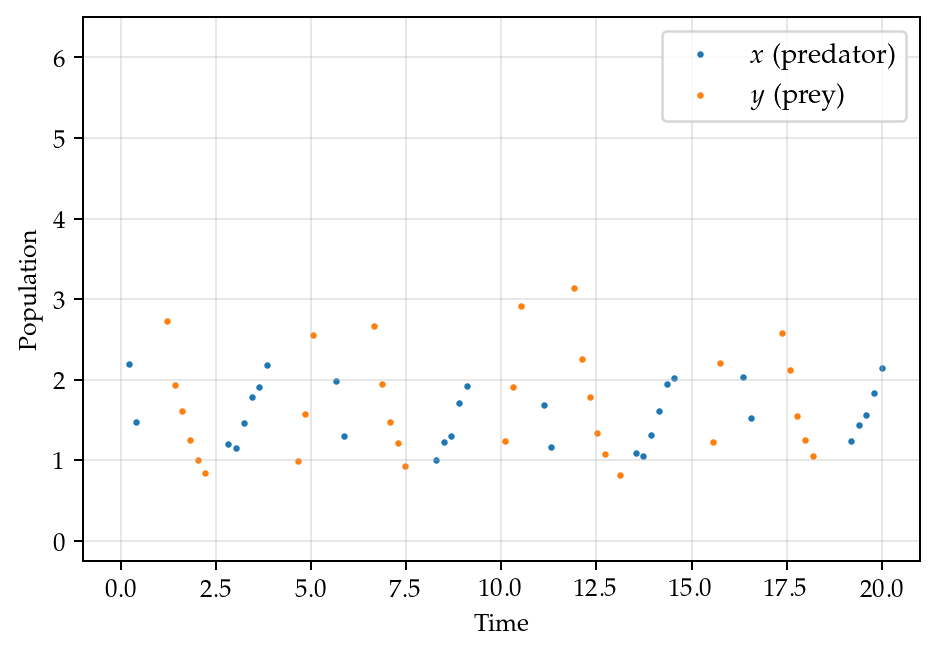

In [27]:
P_trunc_max_70 = remove_points_mean(P, 70, min= False)

plt.scatter(t, P_trunc_max_70[:,0], s=2.5, label="$x$ (predator)")
plt.scatter(t, P_trunc_max_70[:,1], s=2.5, label="$y$ (prey)")
plt.ylabel("Population")
plt.xlabel("Time")
plt.legend()
plt.ylim(-0.25, 6.5)
plt.grid(alpha=0.3)
plt.savefig("figures/Example_max_distance.pdf", bbox_inches="tight")
plt.show()